In [6]:
import torch
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.5)

        # 🔹 Compute flattened size dynamically
        self.flattened_size = self._get_flattened_size()

        self.fc1 = nn.Linear(self.flattened_size, 256)  # Use dynamically computed size
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 6)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.pool(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.pool(x)

        x = x.view(x.size(0), -1)  # Flatten dynamically
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

    def _get_flattened_size(self):
        """Passes a dummy tensor through the conv layers to compute the correct flattened size."""
        with torch.no_grad():
            sample_input = torch.zeros(1, 3, 128, 128)  # Simulate a batch with one image
            x = self.conv1(sample_input)
            x = self.bn1(x)
            x = self.relu(x)
            x = self.pool(x)

            x = self.conv2(x)
            x = self.bn2(x)
            x = self.relu(x)
            x = self.pool(x)

            x = self.conv3(x)
            x = self.bn3(x)
            x = self.relu(x)
            x = self.pool(x)

            return x.view(1, -1).size(1)  # Compute the number of features for fc1

# Instantiate the model
model = CNN()
print(model)
print(f"Computed Flattened Size: {model.flattened_size}")



CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=16384, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=6, bias=True)
)
Computed Flattened Size: 16384


In [26]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data as data

# Define dataset path (modify this to your actual dataset location)
dataset_path = "birds"

# Define transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to match CNN input
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])

# Load dataset (PyTorch automatically labels subfolders)
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# Split into train (80%) and test (20%)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = data.random_split(dataset, [train_size, test_size])

# Create DataLoaders
train_loader = data.DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

# Print class names
print("Classes:", dataset.classes)
print(f"Train Size: {len(train_dataset)}, Test Size: {len(test_dataset)}")


Classes: ['AMERICAN GOLDFINCH', 'BARN OWL', 'CARMINE BEE-EATER', 'DOWNY WOODPECKER', 'EMPEROR PENGUIN', 'FLAMINGO']
Train Size: 480, Test Size: 120


In [29]:
import torch.optim as optim
import torch

# Define device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define loss function & optimizer
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)


# Training loop
num_epochs = 20  # Adjust based on dataset size

def train():
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)  # Move to GPU if available

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

    print("Training complete!")
    # Save model after training
    torch.save(model.state_dict(), "bird_classifier.pth")
    print("Model saved as bird_classifier.pth")

train()



Epoch [1/20], Loss: 0.1634
Epoch [2/20], Loss: 0.1691
Epoch [3/20], Loss: 0.1144
Epoch [4/20], Loss: 0.0923
Epoch [5/20], Loss: 0.0754
Epoch [6/20], Loss: 0.0542
Epoch [7/20], Loss: 0.0361
Epoch [8/20], Loss: 0.0339
Epoch [9/20], Loss: 0.0253
Epoch [10/20], Loss: 0.0195
Epoch [11/20], Loss: 0.0214
Epoch [12/20], Loss: 0.0204
Epoch [13/20], Loss: 0.0093
Epoch [14/20], Loss: 0.0197
Epoch [15/20], Loss: 0.0332
Epoch [16/20], Loss: 0.0341
Epoch [17/20], Loss: 0.0282
Epoch [18/20], Loss: 0.0251
Epoch [19/20], Loss: 0.0114
Epoch [20/20], Loss: 0.0138
Training complete!
Model saved as bird_classifier.pth


Test Accuracy: 97.50%

Per-Class Accuracy:
AMERICAN GOLDFINCH: 100.00% (15/15)
BARN OWL: 100.00% (25/25)
CARMINE BEE-EATER: 100.00% (17/17)
DOWNY WOODPECKER: 100.00% (17/17)
EMPEROR PENGUIN: 91.30% (21/23)
FLAMINGO: 95.65% (22/23)


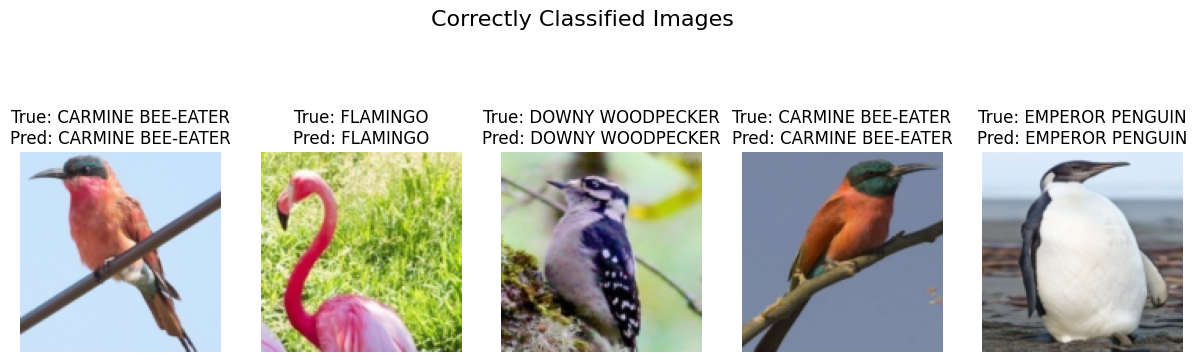

In [34]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import random

# Ensure model is in evaluation mode
# Load the model architecture
model.load_state_dict(torch.load('bird_classifier.pth', map_location=device))


model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 🔹 FIX: Remove any existing TorchCAM hooks before evaluation
for module in model.modules():
    if hasattr(module, "_forward_hooks"):
        module._forward_hooks.clear()

correct = 0
total = 0
misclassified = []  # Store misclassified samples
correctly_classified = []  # Store correctly classified samples
class_correct = {i: 0 for i in range(len(test_loader.dataset.dataset.classes))}
class_total = {i: 0 for i in range(len(test_loader.dataset.dataset.classes))}

# Disable gradient computation for faster inference
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)  # Get class with highest probability

        # Update total and correct counts
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Track per-class accuracy and store images
        for i in range(len(labels)):
            label = labels[i].item()
            class_total[label] += 1
            if predicted[i] == label:
                class_correct[label] += 1
                correctly_classified.append((images[i], label, predicted[i].item()))
            else:
                misclassified.append((images[i], label, predicted[i].item()))

# Compute overall accuracy
accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

# Compute per-class accuracy
print("\nPer-Class Accuracy:")
for i, class_name in enumerate(test_loader.dataset.dataset.classes):
    acc = 100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0
    print(f"{class_name}: {acc:.2f}% ({class_correct[i]}/{class_total[i]})")

# 🔹 Randomize selections
random.shuffle(misclassified)
random.shuffle(correctly_classified)

# 🔹 Show 5 Correctly Classified Images
num_correct = min(5, len(correctly_classified))
if num_correct > 0:
    fig, axes = plt.subplots(1, num_correct, figsize=(15, 5))
    for i in range(num_correct):
        img, true_label, predicted_label = correctly_classified[i]
        img = img.cpu().permute(1, 2, 0).numpy()  # Convert to numpy format
        img = (img * 0.5) + 0.5  # Unnormalize

        axes[i].imshow(img)
        axes[i].set_title(f"True: {test_loader.dataset.dataset.classes[true_label]}\nPred: {test_loader.dataset.dataset.classes[predicted_label]}")
        axes[i].axis("off")

    plt.suptitle("Correctly Classified Images", fontsize=16)
    plt.show()
else:
    print("No correctly classified images found.")



Class Names: ['AMERICAN GOLDFINCH', 'BARN OWL', 'CARMINE BEE-EATER', 'DOWNY WOODPECKER', 'EMPEROR PENGUIN', 'FLAMINGO']
Class Mapping: {0: 'AMERICAN GOLDFINCH', 1: 'BARN OWL', 2: 'CARMINE BEE-EATER', 3: 'DOWNY WOODPECKER', 4: 'EMPEROR PENGUIN', 5: 'FLAMINGO'}


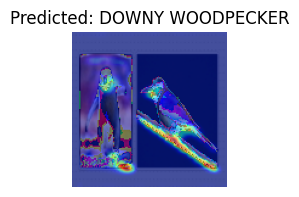

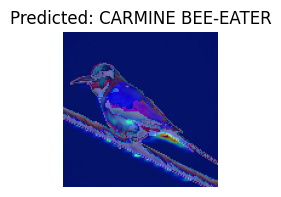

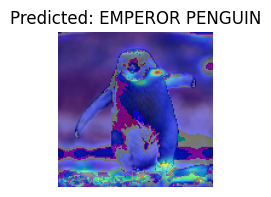

In [36]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchcam.methods import SmoothGradCAMpp
from torchcam.utils import overlay_mask
from torchvision.transforms.functional import to_pil_image
from torchvision import models
from PIL import Image
import os


base_folder = "birds"
class_names = sorted([d for d in os.listdir(base_folder) if os.path.isdir(os.path.join(base_folder, d))])
class_to_idx = {i: class_name for i, class_name in enumerate(class_names)}

# Print class names and their assigned indices
print("Class Names:", class_names)
print("Class Mapping:", class_to_idx)


# Specify the convolutional layer to extract CAMs from
cam_extractor = SmoothGradCAMpp(model, target_layer="conv3")  # Change to last conv layer

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Adjust size if needed
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Standard ImageNet normalization
])

# Function to process a single image and generate CAM
def generate_cam(image_path):
    # Load and preprocess image
    image = Image.open(image_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension

    # Forward pass
    output = model(input_tensor)
    _, predicted = torch.max(output, 1)
    predicted_label = predicted.item()

    # Compute CAM (target class is the predicted class)
    activation_map = cam_extractor(predicted_label, output)

    # Convert image for display
    image_pil = to_pil_image((input_tensor[0].cpu() * 0.5) + 0.5)  # Unnormalize

    # Overlay CAM on image
    result = overlay_mask(image_pil, to_pil_image(activation_map[0], mode="F"), alpha=0.5)

    # Show the image with CAM
    plt.figure(figsize=(2, 6))
    plt.imshow(result)
    plt.title(f"Predicted: {class_to_idx[predicted_label]}")
    plt.axis("off")
    plt.show()

import random  # Import random module for shuffling

def test_folder(folder_path):
    """Processes all images in the folder in a shuffled order."""
    image_files = [f for f in os.listdir(folder_path) if f.endswith((".jpg", ".png", ".jpeg"))]

    random.shuffle(image_files)  # 🔹 Shuffle images randomly

    for image_file in image_files:
        image_path = os.path.join(folder_path, image_file)
        generate_cam(image_path)

# Example usage
test_folder("test")  # Change "test" to your actual test folder path

